In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
outfile = "runXX-VASAseq-IGH-HUMAN-shared-clones.xlsx"

## Read data

In [3]:
chain = "IGH"
mydir = "VASAseq/"
myfiles = [x for x in os.listdir(mydir) if chain in x]
myfiles[:10]

['GCTTCTTC_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'ATGAGCAG_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'CGTAGAAG_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'GCGTATAG_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'ACGAACAC_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'TTCAGCGT_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'GACAAACC_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'GCCATCTT_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'CCTCTCAA_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'GGACCTTT_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv']

In [4]:
# Read well positions and barcodes
df_wells = pd.read_excel("/home/barbera/Downloads/VASAseq/celseq2_primers.xlsx")
df_wells = df_wells.rename(columns={'Well Position': 'Patient', 'Cell Barcode': 'Sample'})
cols = ['Patient', 'Sample']
df_wells = df_wells[cols]
df_wells.head()

,Patient,Sample
0,A1,CGTCTAAT
1,A2,AGACTCGT
2,A3,GCACGTCA
3,A4,TCAACGAC
4,A5,ATTTAGCG


In [5]:
def readCdr3File(f):
    barcode = f.split("/")[-1].split("_")[0]
    df_cdr3 = pd.read_csv(f, sep="\t", header=None)
    df_cdr3 = df_cdr3.rename(columns={0: "freq", 4: "cdr3pep"})
    df = df_cdr3.groupby("cdr3pep").agg({'freq': 'nunique'})
    df = df.reset_index()
    df["Sample"] = barcode
    return(df)

f = mydir + myfiles[0]
df = readCdr3File(f)
df.head()

,cdr3pep,freq,Sample
0,CARDSGHSYALDVW,12,GCTTCTTC


In [6]:
for f in myfiles[1:]:
    f = mydir + f
    df = pd.concat([df, readCdr3File(f)], ignore_index=True)
df.tail()

,cdr3pep,freq,Sample
3300,CARLGYDSSGYYYGELYFDYW,1,CGGTAATC
3301,CARDPEWLGYYYYCMDVW,1,ATCGACGA
3302,CARHSWYTSGWPSDYW,1,ATCGACGA
3303,CARHSWYTSGWPSDYW,1,GTTCTTGC
3304,CATRGYCSGASCYKVYYYGMDVW,4,GGGGATTT


In [7]:
df = df.merge(df_wells, how="left", on="Sample")
df.head()

,cdr3pep,freq,Sample,Patient
0,CARDSGHSYALDVW,12,GCTTCTTC,I21
1,CADIRAYDSPLW,1,ATGAGCAG,E5
2,CADIWADDSPLW,1,ATGAGCAG,E5
3,CADIWAYDSPLR,1,ATGAGCAG,E5
4,CADIWAYDSPLW,49,ATGAGCAG,E5


In [8]:
df_total = df.groupby("Sample").agg({"freq": sum})
df_total = df_total.reset_index()
df_total = df_total.rename(columns={'freq': 'totalreads'})
df_total.head()

,Sample,totalreads
0,AAACAGGC,7
1,AAAGGCTG,1
2,AACCGCTT,3
3,AACCGGAA,4
4,AACCTGCT,3


In [9]:
# Result columns should be: Patient, Sample, cdr3pep, freq, totalreads
df = pd.merge(df, df_total, on="Sample")
df.head()

,cdr3pep,freq,Sample,Patient,totalreads
0,CARDSGHSYALDVW,12,GCTTCTTC,I21,12
1,CADIRAYDSPLW,1,ATGAGCAG,E5,53
2,CADIWADDSPLW,1,ATGAGCAG,E5,53
3,CADIWAYDSPLR,1,ATGAGCAG,E5,53
4,CADIWAYDSPLW,49,ATGAGCAG,E5,53


In [10]:
df.tail()

,cdr3pep,freq,Sample,Patient,totalreads
3300,CARLGYDSSGYYYGELYFDYW,1,CGGTAATC,H3,1
3301,CARDPEWLGYYYYCMDVW,1,ATCGACGA,P2,2
3302,CARHSWYTSGWPSDYW,1,ATCGACGA,P2,2
3303,CARHSWYTSGWPSDYW,1,GTTCTTGC,L23,1
3304,CATRGYCSGASCYKVYYYGMDVW,4,GGGGATTT,M18,4


In [11]:
df['perc'] = 100 * df['freq'] / df['totalreads']
df.head()

,cdr3pep,freq,Sample,Patient,totalreads,perc
0,CARDSGHSYALDVW,12,GCTTCTTC,I21,12,100.000000
1,CADIRAYDSPLW,1,ATGAGCAG,E5,53,1.886792
2,CADIWADDSPLW,1,ATGAGCAG,E5,53,1.886792
3,CADIWAYDSPLR,1,ATGAGCAG,E5,53,1.886792
4,CADIWAYDSPLW,49,ATGAGCAG,E5,53,92.452830


In [12]:
# Rename the Sample column and replace it with the Well IDs
df = df.rename(columns={'Sample': 'Barcode'})
df['Sample'] = df['Patient']
df.head()

,cdr3pep,freq,Barcode,Patient,totalreads,perc,Sample
0,CARDSGHSYALDVW,12,GCTTCTTC,I21,12,100.000000,I21
1,CADIRAYDSPLW,1,ATGAGCAG,E5,53,1.886792,E5
2,CADIWADDSPLW,1,ATGAGCAG,E5,53,1.886792,E5
3,CADIWAYDSPLR,1,ATGAGCAG,E5,53,1.886792,E5
4,CADIWAYDSPLW,49,ATGAGCAG,E5,53,92.452830,E5


## Determine overlap (shared clones) and the direction

In [13]:
ids = list(df['Sample'].unique())
ids[:10]

['I21', 'E5', 'H24', 'F9', 'P8', 'J8', 'B15', 'C13', 'M7', 'A21']

In [14]:
def directionShared(df, idA, idB):
    df_A = df[df['Sample'] == idA]
    df_B = df[df['Sample'] == idB]
    df_pair = pd.merge(df_A, df_B, on="cdr3pep")
    sum_A = df_pair["perc_x"].sum()
    sum_B = df_pair["perc_y"].sum()
    if sum_B > sum_A:
        idA, idB = idB, idA
        sum_A, sum_B = sum_B, sum_A
    return(idA, idB, sum_A, sum_B)
directionShared(df, "DO-004V3-P5_S123", "DO-004V3-P8_S127")

('DO-004V3-P5_S123', 'DO-004V3-P8_S127', 0.0, 0.0)

In [15]:
sources = list()
targets = list()
impacts_source = list()
impacts_target = list()
for i in range(len(ids)-1):
    for j in range(i+1, len(ids)):
        idA = ids[i]
        idB = ids[j]
        (source, target, impact_source, impact_target) = directionShared(df, idA, idB)
        sources.append(source)
        targets.append(target)
        impacts_source.append(impact_source)
        impacts_target.append(impact_target)
df_shared = pd.DataFrame({'source': sources, 'target': targets, 'impact_source': impacts_source, 'impact_target': impacts_target})
df_shared.head()

,source,target,impact_source,impact_target
0,I21,E5,0.0,0.0
1,I21,H24,0.0,0.0
2,I21,F9,0.0,0.0
3,I21,P8,0.0,0.0
4,I21,J8,0.0,0.0


In [16]:
# Add patient columns for the source and the target
cols = ["Patient", "Sample"]
df_shared['patient_source'] = df_shared['source']
df_shared['patient_target'] = df_shared['target']
cols = ["source", "target", "impact_source", "impact_target", "patient_source", "patient_target"]
df_shared = df_shared[cols]
df_shared.head()

,source,target,impact_source,impact_target,patient_source,patient_target
0,I21,E5,0.0,0.0,I21,E5
1,I21,H24,0.0,0.0,I21,H24
2,I21,F9,0.0,0.0,I21,F9
3,I21,P8,0.0,0.0,I21,P8
4,I21,J8,0.0,0.0,I21,J8


In [17]:
# sort on impact on the target and then on impact of the source
df_shared = df_shared.sort_values(by=["impact_target", "impact_source"], ascending=False)
df_shared = df_shared.reset_index()
df_shared.head()

,index,source,target,impact_source,impact_target,patient_source,patient_target
0,3208,O4,A6,100.0,100.0,O4,A6
1,3218,O4,P5,100.0,100.0,O4,P5
2,3262,O4,O12,100.0,100.0,O4,O12
3,3273,O4,O3,100.0,100.0,O4,O3
4,3327,O4,B22,100.0,100.0,O4,B22


In [18]:
same_pt = list()
for i in range(len(df_shared)):
    if df_shared['patient_source'][i] == df_shared['patient_target'][i]:
        same_pt.append("same")
    else:
        same_pt.append("different")
df_shared["Same patient"] = same_pt
df_shared.head()

,index,source,target,impact_source,impact_target,patient_source,patient_target,Same patient
0,3208,O4,A6,100.0,100.0,O4,A6,different
1,3218,O4,P5,100.0,100.0,O4,P5,different
2,3262,O4,O12,100.0,100.0,O4,O12,different
3,3273,O4,O3,100.0,100.0,O4,O3,different
4,3327,O4,B22,100.0,100.0,O4,B22,different


In [19]:
df_shared.to_excel(outfile)
print("Wrote", outfile, "to disk")

Wrote runXX-VASAseq-IGH-HUMAN-shared-clones.xlsx to disk


## Visualize it

In [20]:
df_shared = df_shared[(df_shared["impact_source"] != 0) & (df_shared["impact_target"] != 0)]
df_shared = df_shared.reset_index()
df_shared.head()

,level_0,index,source,target,impact_source,impact_target,patient_source,patient_target,Same patient
0,0,3208,O4,A6,100.0,100.0,O4,A6,different
1,1,3218,O4,P5,100.0,100.0,O4,P5,different
2,2,3262,O4,O12,100.0,100.0,O4,O12,different
3,3,3273,O4,O3,100.0,100.0,O4,O3,different
4,4,3327,O4,B22,100.0,100.0,O4,B22,different


In [21]:
def makeScatter(x,y,txt,color,xlabel,ylabel,plotfile):
    fig, ax = plt.subplots(figsize=(15,15))
    ax.scatter(x, y, color=color)

    for i, txt in enumerate(txt):
        ax.annotate(txt, (x[i], y[i]))
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Add red dotted line
    ax.plot([-1, 100], [-1, 100], c='w', linestyle=":")
    
    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

In [22]:
f = lambda x,y: x + "->" + y
df_shared['txt'] = [x for x in map(f, df_shared['source'], df_shared['target'])]
df_shared['color'] = "blue"
df_shared.loc[df_shared["Same patient"] == "same", 'color'] = "purple"
df_shared.head()

,level_0,index,source,target,impact_source,impact_target,patient_source,patient_target,Same patient,txt,color
0,0,3208,O4,A6,100.0,100.0,O4,A6,different,O4->A6,blue
1,1,3218,O4,P5,100.0,100.0,O4,P5,different,O4->P5,blue
2,2,3262,O4,O12,100.0,100.0,O4,O12,different,O4->O12,blue
3,3,3273,O4,O3,100.0,100.0,O4,O3,different,O4->O3,blue
4,4,3327,O4,B22,100.0,100.0,O4,B22,different,O4->B22,blue


Wrote runXX-VASAseq-IGH-HUMAN-shared-clones-all.pdf to disk


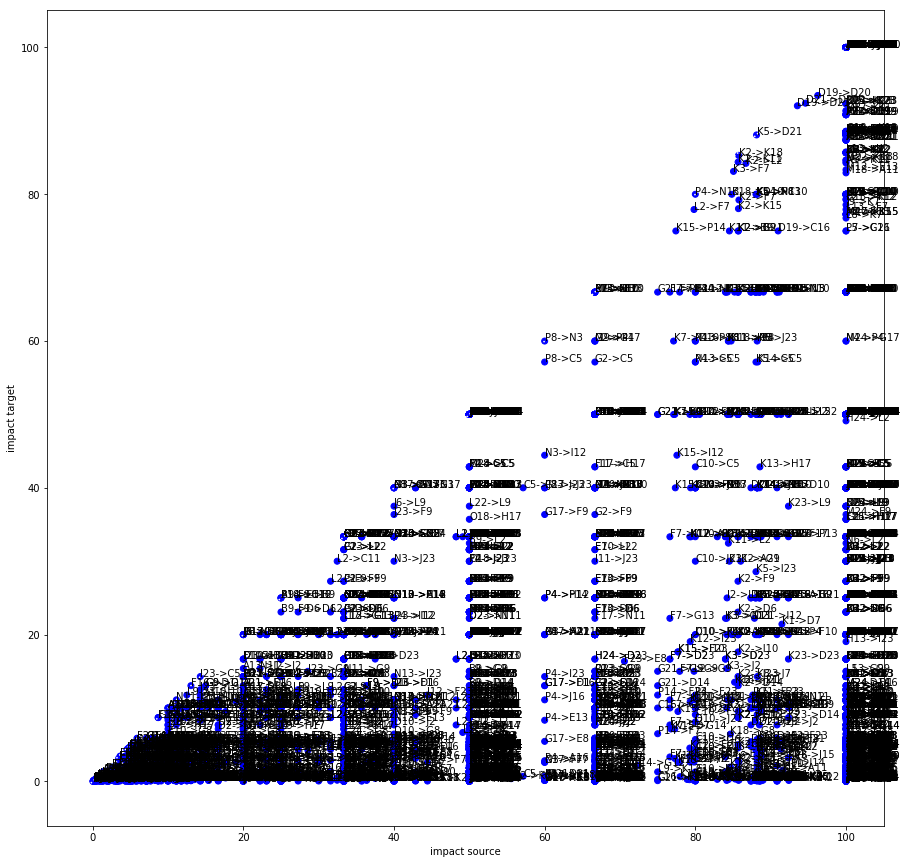

In [23]:
plotfile = outfile.replace(".xlsx", "-all.pdf")
makeScatter(df_shared["impact_source"], df_shared["impact_target"], df_shared['txt'], df_shared['color'], "impact source", "impact target", plotfile)

In [24]:
# Only show things that are different
df_shared_filter = df_shared.copy()
df_shared_filter = df_shared_filter[df_shared_filter["Same patient"] == "different"]
cols = ["source", "target", "impact_source", "impact_target", "Same patient", "txt", "color"]
df_shared_filter = df_shared_filter[cols]
df_shared_filter = df_shared_filter.reset_index()
df_shared_filter.head()

,index,source,target,impact_source,impact_target,Same patient,txt,color
0,0,O4,A6,100.0,100.0,different,O4->A6,blue
1,1,O4,P5,100.0,100.0,different,O4->P5,blue
2,2,O4,O12,100.0,100.0,different,O4->O12,blue
3,3,O4,O3,100.0,100.0,different,O4->O3,blue
4,4,O4,B22,100.0,100.0,different,O4->B22,blue


Wrote runXX-VASAseq-IGH-HUMAN-shared-clones-different-ids.pdf to disk


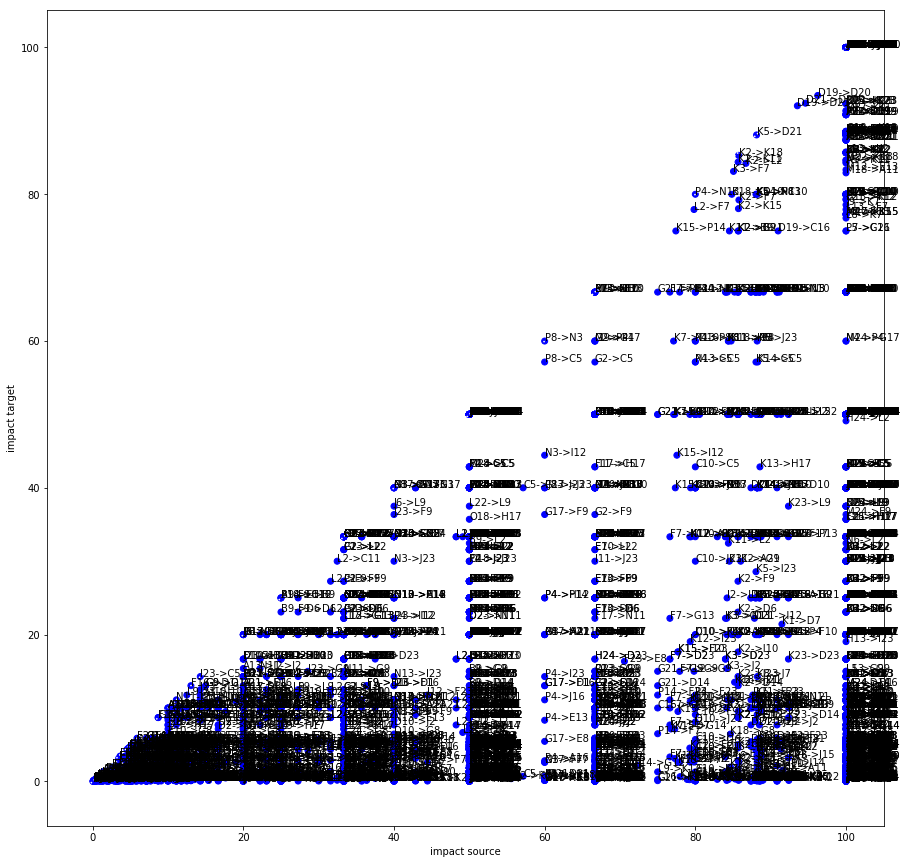

In [25]:
plotfile = outfile.replace(".xlsx", "-different-ids.pdf")
makeScatter(df_shared_filter["impact_source"], df_shared_filter["impact_target"], df_shared_filter['txt'], df_shared_filter['color'], "impact source", "impact target", plotfile)

## Calculate common/public clones

In [26]:
df.head()

,cdr3pep,freq,Barcode,Patient,totalreads,perc,Sample
0,CARDSGHSYALDVW,12,GCTTCTTC,I21,12,100.000000,I21
1,CADIRAYDSPLW,1,ATGAGCAG,E5,53,1.886792,E5
2,CADIWADDSPLW,1,ATGAGCAG,E5,53,1.886792,E5
3,CADIWAYDSPLR,1,ATGAGCAG,E5,53,1.886792,E5
4,CADIWAYDSPLW,49,ATGAGCAG,E5,53,92.452830,E5


In [27]:
concat = lambda x: ", ".join(list(set(x)))
df_clone_occurrence = df.groupby('cdr3pep').agg({'Patient': [pd.Series.nunique, concat], 'Sample': [pd.Series.nunique, concat]})

In [28]:
df_clone_occurrence = df_clone_occurrence.rename(columns={'<lambda>': 'names'})
df_clone_occurrence.head()

Patient                    Sample                  
                 nunique             names nunique             names
cdr3pep                                                             
AAGFVGGQWPQFDHW        1                K2       1                K2
AARHPWYTSGGPPDYW       1               K14       1               K14
AASFSWGQWLQFDYW        1                K2       1                K2
C                      4  K14, D20, K2, K3       4  K14, D20, K2, K3
CAADGSTATTGFLGYW       1               K13       1               K13

In [29]:
# Get percentage columns for each sample
df_pivot = df.pivot_table(index='cdr3pep', columns=['Patient','Sample'], values='perc', aggfunc='sum')
df_pivot = df_pivot.reset_index()
df_pivot.head()

Patient,cdr3pep,A11,A12,A13,A15,A16,A18,A2,A21,A5,...,P15,P17,P19,P2,P3,P4,P5,P7,P8,P9
Sample,,A11,A12,A13,A15,A16,A18,A2,A21,A5,...,P15,P17,P19,P2,P3,P4,P5,P7,P8,P9
0,AAGFVGGQWPQFDHW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AARHPWYTSGGPPDYW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AASFSWGQWLQFDYW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CAADGSTATTGFLGYW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df_clone_occurrence = pd.merge(df_clone_occurrence, df_pivot, on='cdr3pep')
df_clone_occurrence = df_clone_occurrence.sort_values(by=[('Patient','nunique'), ('Sample','nunique')], ascending=False)
df_clone_occurrence = df_clone_occurrence.reset_index()
df_clone_occurrence.head()

/home/barbera/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


index             cdr3pep Patient  \
                            nunique   
0  1992     CASFLGGQWLQFDYW      57   
1   891    CARHSWYTSGWPSDYW      43   
2  1797     CARVKEYDFGGMDVW      38   
3   318  CARDPEWLGYYYYYMDVW      24   
4   556     CARGGYNRRREFDYW      23   

                                                      Sample  \
                                               names nunique   
0  J21, F16, G21, P13, I15, F9, O4, K5, K8, I2, I...      57   
1  K14, F16, I11, N13, K5, F9, J10, K8, L23, M21,...      43   
2  N10, A13, J21, F17, K5, M5, N11, K3, J7, K8, P...      38   
3  H21, M9, N13, K5, P14, I23, A11, P4, J16, N5, ...      24   
4  K23, D12, K6, P7, J8, A11, F11, J11, E8, O5, C...      23   

                                                           A11 A12   A13  \
                                               names       A11 A12   A13   
0  J21, F16, G21, P13, I15, F9, O4, K5, K8, I2, I...       NaN NaN   NaN   
1  K14, F16, I11, N13, K5, F9, J10, K8, L23, M21,...       NaN NaN   NaN   
2  N10, A13, J21, F17, K5, M5, N11, K3, J7, K8, P...       NaN NaN  10.0   
3  H21, M9, N13, K5, P14, I23, A11, P4, J16, N5, ...  0.502513 NaN   NaN   
4  K23, D12, K6, P7, J8, A11, F11, J11, E8, O5, C...  0.502513 NaN   NaN   

     A15  ...   P15    P17    P19    P2     P3    P4     P5         P7    P8  \
     A15  ...   P15    P17    P19    P2     P3    P4     P5         P7    P8   
0    NaN  ...  50.0    NaN    NaN   NaN    NaN   NaN  100.0        NaN   NaN   
1    NaN  ...   NaN  100.0  100.0  50.0    NaN  20.0    NaN        NaN  40.0   
2  100.0  ...   NaN    NaN    NaN   NaN  100.0  20.0    NaN  66.666667   NaN   
3    NaN  ...   NaN    NaN    NaN   NaN    NaN  60.0    NaN        NaN  20.0   
4    NaN  ...   NaN    NaN    NaN   NaN    NaN   NaN    NaN  33.333333   NaN   

      P9  
      P9  
0    NaN  
1    NaN  
2  100.0  
3    NaN  
4    NaN  

[5 rows x 240 columns]

In [31]:
# Only keep entries that are in 2 or more Samples
print("All cdr3's:", len(df_clone_occurrence))
df_clone_occurrence = df_clone_occurrence[df_clone_occurrence[('Sample','nunique')] > 1]
print("cdr3's in > 1 sample:", len(df_clone_occurrence))

All cdr3's: 2863
cdr3's in > 1 sample: 106


In [32]:
occurrence_file = outfile.replace(".xlsx", "-occurrence.xlsx")
df_clone_occurrence.to_excel(occurrence_file)
print("Wrote", occurrence_file, "to disk")

Wrote runXX-VASAseq-IGH-HUMAN-shared-clones-occurrence.xlsx to disk
